# Support vector machine binary classificator with QP problem solved with Sequential Minimal optimization algorithm

In [84]:
from typing import Literal

# plots
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

# splitter, scaler and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
)

# base class for classifier (compatable with sklearn)
from sklearn.base import ClassifierMixin

# C++ module implementing SMO (https://github.com/egorliap/qpproblem-smo-solver-module)
import qpproblem_smo_solver as qp_solver

In [85]:
# Binary classifier configuration

class SVMClassifier(ClassifierMixin):
    def __init__(
        self,
        kernel: Literal["linear", "polynomial", "rbf"] = "linear",
        C=1.0,
        tol=1e-3,
        max_iter=10000,
    ):
        self.C = C
        self.tol = tol
        self.max_iter = max_iter
        self.kernel = kernel
        self.alpha = None
        self.b = 0
        self.errors = None

    def fit(self, X: np.ndarray = None, y: np.ndarray = None):
        """
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (n_samples)
        Training data targets
        """
        self.n_samples, n_features = X.shape
        self.alpha = np.zeros(self.n_samples)
        self.b = 0
        self.X = X
        self.y = y
        self.solver = qp_solver.QPSolver(
            list(X), list(y), self.kernel, self.C, self.tol, self.max_iter,logs=True
        )

        self.solver.solve()
        self.alpha = self.solver.get_alpha()
        self.b = self.solver.get_b()

    def objective(self, X: np.ndarray):
        ans = self.solver.output(X)
        result = np.sign(ans)
        result[result == 0] = -1
        return result

    def decision_function(self, X):
        return np.array(self.solver.output(X))

    def predict(self, X=None):
        """
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        """
        return self.objective(X)

In [86]:
def generate_sparse_2D_dataset(
    n_samples: int, file_name: str = "datasets/two-dim-dataset-for-visualisation.csv"
):
    samples_per_class = n_samples // 2  # Controls sparsity
    class0_center = [1, 1]
    class1_center = [5, 5]
    noise_level = 1  # Keep low for clear separation

    # Generate data
    class0 = np.random.normal(
        loc=class0_center, scale=noise_level, size=(samples_per_class, 2)
    )
    class1 = np.random.normal(
        loc=class1_center, scale=noise_level, size=(samples_per_class, 2)
    )

    # Create DataFrame
    df = pd.DataFrame(np.vstack([class0, class1]), columns=["X1", "X2"])
    df["Outcome"] = [0] * samples_per_class + [1] * samples_per_class

    # Save to CSV
    df.to_csv(file_name, index=False)

In [87]:
def plot_svm_linear_boundary(clf, X, y):
    plt.figure(figsize=(8, 6))

    # Plot data points
    plt.scatter(
        X[y == -1][:, 0], X[y == -1][:, 1], color="blue", label="Class -1", s=25
    )
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color="red", label="Class 1", s=25)

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)

    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(
        XX,
        YY,
        Z,
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )

    plt.title("SVM Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()

    plt.show()

In [88]:
file_path = "datasets/two-dim-dataset-for-visualisation.csv"
generate_sparse_2D_dataset(1000, file_path)
df = pd.read_csv(file_path)

In [89]:
X = df.drop(
    [
        "Outcome",
    ],
    axis=1,
)
y = df["Outcome"]
y = y.replace(0, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

scaler = StandardScaler()

scaled_X_train = np.array(scaler.fit_transform(X_train))
scaled_X_test = np.array(scaler.transform(X_test))

y_test = np.array(y_test)


In [90]:
svc_model_linear = SVMClassifier(C=1, kernel="linear", tol=1e-3, max_iter=100000)
svc_model_poly = SVMClassifier(C=1, kernel="polynomial", tol=1e-3, max_iter=100000)
svc_model_rbf = SVMClassifier(C=1, kernel="rbf", tol=1e-3, max_iter=100000)

In [91]:
%%timeit -n3 -r3
svc_model = SVMClassifier(C=1, kernel="polynomial", tol=1e-3, max_iter=100000)

svc_model.fit(scaled_X_train, np.array(y_train))

svc_pred = svc_model.predict(np.array(scaled_X_test))


86.1 ms ± 6.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


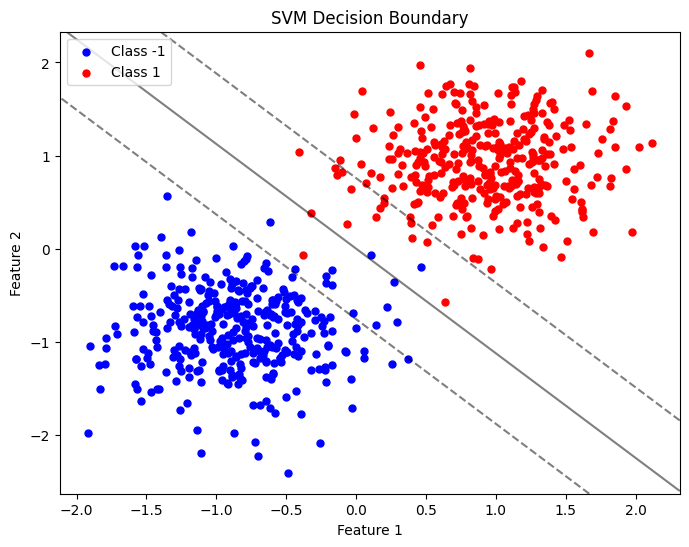

              precision    recall  f1-score   support

          -1       1.00      0.99      1.00       139
           1       0.99      1.00      1.00       161

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [92]:
svc_model_linear.fit(scaled_X_train, np.array(y_train))

svc_pred = svc_model_linear.predict(np.array(scaled_X_test))

plot_svm_linear_boundary(svc_model_linear, scaled_X_train, np.array(y_train))
print(classification_report(y_test, svc_pred))

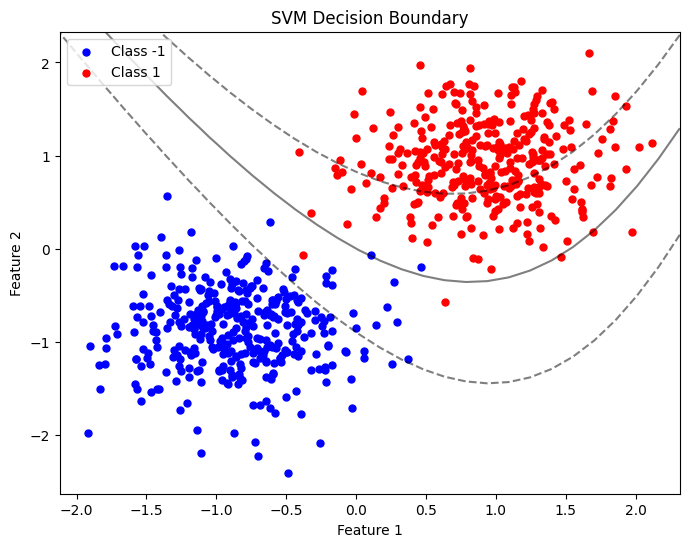

              precision    recall  f1-score   support

          -1       0.97      1.00      0.99       139
           1       1.00      0.98      0.99       161

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [93]:
svc_model_poly.fit(scaled_X_train, np.array(y_train))

svc_pred = svc_model_poly.predict(np.array(scaled_X_test))

plot_svm_linear_boundary(svc_model_poly, scaled_X_train, np.array(y_train))
print(classification_report(y_test, svc_pred))

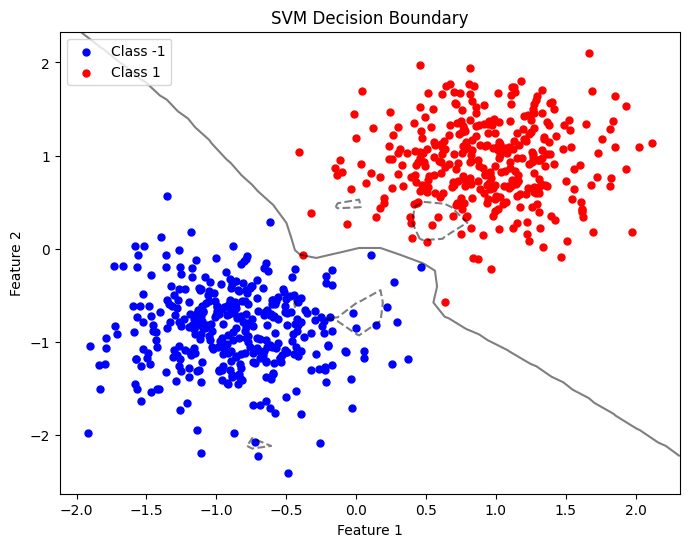

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       139
           1       1.00      1.00      1.00       161

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [94]:
svc_model_rbf.fit(scaled_X_train, np.array(y_train))

svc_pred = svc_model_rbf.predict(np.array(scaled_X_test))

plot_svm_linear_boundary(svc_model_rbf, scaled_X_train, np.array(y_train))
print(classification_report(y_test, svc_pred))